# Logisitic Regression and Support Vector Machines Minilab

You are to perform predictive analysis (classification) upon a data set: model the dataset using methods we have discussed in class: logistic regression and support vector machines, and making conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 10% of the final grade. You may complete this assignment in teams of as many as three people.  




By Martin Garcia, Joanna Duran, Daniel Byrne

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

from sklearn.linear_model import SGDClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Business Understanding

Our objective is to create a logistic regression model and a support vector machine model for the classification of each image. We will determine which is a better model based on prediction accuracy, training time, and efficiency.The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6,000 images per class. 

Our objective is to create a logistic regression model and a support vector machine model for the classification of each image in our test set. We will determine which model is best suited for this standard classification task based on a comparison on their prediction accuracy, training times, and computational efficiency.

## Data Meaning Type

### The CIFAR-10 dataset

We are using the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The dataset includes are 50000(80%) training images and 10000(20%) test images broken in to 5 pre-randomized training batches and 1 test batch.

Each training batch contains 10,000 observations with a row vector of length 3072 representative of color image of 32x32 pixels. The first 1024 columns consist of red values, followed by green, and blue. The data also incorporates labels ranging from 0 to 9 and are listed below.

* airplane : 0
* automobile : 1
* bird : 2
* cat : 3
* deer : 4
* dog : 5
* frog : 6
* horse : 7
* ship : 8
* truck : 9

The test batch contains 1000 randomly-selected images from each class. The 5 training batches are randomized and contain a variable number of images from each class. 

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

## Simple Statistics

In [2]:
#load the data, reshape to 32x32 matrix per color, transpose matrices
def load_cfar10_batch(path, batch_id = None, reshape = True):
    """
    Argument:
    path -- path the datasets
    batch_id -- id of the batch (1 to 5) to load
    
    Returns:
    parameters -- python dictionary containing:
                    X -- features
                    Y -- labels
    """
    if batch_id is not None:
        filepath = path + 'data_batch_' + str(batch_id)
    else:
        filepath = path
        
    with open(filepath, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
    
    if reshape:    
        X = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        Y = np.array(batch['labels'])
    else:
        X = batch['data']
        Y = np.array(batch['labels'])
        
    return X, Y


Stats of batch #2:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 984
Label Counts of [1](AUTOMOBILE) : 1007
Label Counts of [2](BIRD) : 1010
Label Counts of [3](CAT) : 995
Label Counts of [4](DEER) : 1010
Label Counts of [5](DOG) : 988
Label Counts of [6](FROG) : 1008
Label Counts of [7](HORSE) : 1026
Label Counts of [8](SHIP) : 987
Label Counts of [9](TRUCK) : 985

Example of Image 5687:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


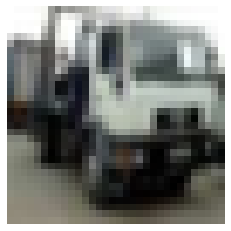

In [3]:
#load labels for our label
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#display images
def display_stats(data, batch_id, sample_id):
    features, labels = load_cfar10_batch(data, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

batch_id = random.randint(1,5)
sample_id = random.randint(1,10000)
display_stats( "data/", batch_id, sample_id)

## Models

In this section we will create a logistic regression model and a support vector machine model for the classification task involved with your dataset.  We will assess how well each model performs (use 80/20 training/testing split)and adjust parameters of the models to make them more accurate. 

*If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

In [8]:
# Build Logistic Regression Model with Stochastic Gradient Descent 
X,Y = load_cfar10_batch("data/",1,False)

for n in range(2,6):
    x,y = load_cfar10_batch("data/",n,False)
    X = np.concatenate((X,x),axis=0)
    Y = np.concatenate((Y,y),axis=0)

test_X,test_Y = load_cfar10_batch("data/test_batch",None,False)
#labelnames = unpickle("data/batches.meta")

sgdlr = SGDClassifier(alpha=0.001, max_iter=100, tol=1e-3, verbose = 1,loss="log")

print("Data shape: ",X.shape)
print("Labels shape: ",Y.shape)

print("Test Data shape: ",test_X.shape)
print("Test Labels shape: ",test_Y.shape)



Data shape:  (50000, 3072)
Labels shape:  (50000,)
Test Data shape:  (10000, 3072)
Test Labels shape:  (10000,)


In [ ]:
sgdlr.fit(X,Y)
score = sgdlr.score(test_X,test_Y)
print(score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 2422.63, NNZs: 3072, Bias: -85.832479, T: 50000, Avg. loss: 668837.181515
Total training time: 0.21 seconds.
-- Epoch 2
Norm: 1589.27, NNZs: 3072, Bias: -92.813852, T: 100000, Avg. loss: 71961.334502
Total training time: 0.45 seconds.
-- Epoch 3
Norm: 1225.35, NNZs: 3072, Bias: -97.130767, T: 150000, Avg. loss: 42759.256896
Total training time: 0.67 seconds.
-- Epoch 4
Norm: 1024.07, NNZs: 3072, Bias: -100.072936, T: 200000, Avg. loss: 29997.682711
Total training time: 0.88 seconds.
-- Epoch 5
Norm: 896.81, NNZs: 3072, Bias: -102.415159, T: 250000, Avg. loss: 23072.033376
Total training time: 1.10 seconds.
-- Epoch 6
Norm: 820.93, NNZs: 3072, Bias: -104.417561, T: 300000, Avg. loss: 18861.837587
Total training time: 1.31 seconds.
-- Epoch 7
Norm: 753.75, NNZs: 3072, Bias: -105.999262, T: 350000, Avg. loss: 15789.128614
Total training time: 1.53 seconds.
-- Epoch 8
Norm: 696.53, NNZs: 3072, Bias: -107.353700, T: 400000, Avg. loss: 13596.917304
Total training time: 1.75 

Norm: 241.19, NNZs: 3072, Bias: -129.300249, T: 3300000, Avg. loss: 1523.052051
Total training time: 15.19 seconds.
-- Epoch 67
Norm: 239.65, NNZs: 3072, Bias: -129.461318, T: 3350000, Avg. loss: 1500.141309
Total training time: 15.43 seconds.
-- Epoch 68
Norm: 237.77, NNZs: 3072, Bias: -129.607580, T: 3400000, Avg. loss: 1472.438198
Total training time: 15.69 seconds.
-- Epoch 69
Norm: 236.01, NNZs: 3072, Bias: -129.754921, T: 3450000, Avg. loss: 1462.283439
Total training time: 15.96 seconds.
-- Epoch 70
Norm: 234.30, NNZs: 3072, Bias: -129.906535, T: 3500000, Avg. loss: 1454.204204
Total training time: 16.20 seconds.
-- Epoch 71
Norm: 232.79, NNZs: 3072, Bias: -130.055050, T: 3550000, Avg. loss: 1418.276221
Total training time: 16.44 seconds.
-- Epoch 72
Norm: 230.97, NNZs: 3072, Bias: -130.199415, T: 3600000, Avg. loss: 1405.684556
Total training time: 16.68 seconds.
-- Epoch 73
Norm: 228.94, NNZs: 3072, Bias: -130.343755, T: 3650000, Avg. loss: 1384.479780
Total training time: 16.

Norm: 340.42, NNZs: 3072, Bias: 2.069840, T: 1600000, Avg. loss: 2263.814117
Total training time: 8.35 seconds.
-- Epoch 33
Norm: 335.93, NNZs: 3072, Bias: 2.016935, T: 1650000, Avg. loss: 2214.063858
Total training time: 8.62 seconds.
-- Epoch 34
Norm: 330.51, NNZs: 3072, Bias: 1.960607, T: 1700000, Avg. loss: 2130.293151
Total training time: 8.86 seconds.
-- Epoch 35
Norm: 325.81, NNZs: 3072, Bias: 1.912199, T: 1750000, Avg. loss: 2038.732322
Total training time: 9.11 seconds.
-- Epoch 36
Norm: 321.57, NNZs: 3072, Bias: 1.865932, T: 1800000, Avg. loss: 2004.074490
Total training time: 9.36 seconds.
-- Epoch 37
Norm: 317.82, NNZs: 3072, Bias: 1.822033, T: 1850000, Avg. loss: 1953.596770
Total training time: 9.59 seconds.
-- Epoch 38
Norm: 314.07, NNZs: 3072, Bias: 1.778196, T: 1900000, Avg. loss: 1894.779899
Total training time: 9.82 seconds.
-- Epoch 39
Norm: 309.02, NNZs: 3072, Bias: 1.740874, T: 1950000, Avg. loss: 1836.789612
Total training time: 10.11 seconds.
-- Epoch 40
Norm: 3

Norm: 194.79, NNZs: 3072, Bias: 0.253932, T: 4900000, Avg. loss: 716.831554
Total training time: 24.38 seconds.
-- Epoch 99
Norm: 193.56, NNZs: 3072, Bias: 0.236904, T: 4950000, Avg. loss: 714.077557
Total training time: 24.61 seconds.
-- Epoch 100
Norm: 192.69, NNZs: 3072, Bias: 0.220104, T: 5000000, Avg. loss: 699.047864
Total training time: 24.84 seconds.
-- Epoch 1
Norm: 2230.63, NNZs: 3072, Bias: -18.567323, T: 50000, Avg. loss: 543018.742687
Total training time: 0.25 seconds.
-- Epoch 2
Norm: 1502.28, NNZs: 3072, Bias: -19.513488, T: 100000, Avg. loss: 62473.812634
Total training time: 0.49 seconds.
-- Epoch 3
Norm: 1157.60, NNZs: 3072, Bias: -20.139289, T: 150000, Avg. loss: 36625.870028
Total training time: 0.72 seconds.
-- Epoch 4
Norm: 954.20, NNZs: 3072, Bias: -20.561840, T: 200000, Avg. loss: 25615.556400
Total training time: 0.95 seconds.
-- Epoch 5
Norm: 857.23, NNZs: 3072, Bias: -20.812977, T: 250000, Avg. loss: 20019.426806
Total training time: 1.19 seconds.
-- Epoch 6


Norm: 217.03, NNZs: 3072, Bias: -24.156433, T: 3200000, Avg. loss: 1382.030077
Total training time: 15.95 seconds.
-- Epoch 65
Norm: 215.06, NNZs: 3072, Bias: -24.184456, T: 3250000, Avg. loss: 1352.117582
Total training time: 16.19 seconds.
-- Epoch 66
Norm: 213.60, NNZs: 3072, Bias: -24.203308, T: 3300000, Avg. loss: 1330.944520
Total training time: 16.47 seconds.
-- Epoch 67
Norm: 211.55, NNZs: 3072, Bias: -24.231365, T: 3350000, Avg. loss: 1304.961104
Total training time: 16.73 seconds.
-- Epoch 68
Norm: 210.25, NNZs: 3072, Bias: -24.258012, T: 3400000, Avg. loss: 1291.640834
Total training time: 16.97 seconds.
-- Epoch 69
Norm: 208.27, NNZs: 3072, Bias: -24.280717, T: 3450000, Avg. loss: 1278.480946
Total training time: 17.21 seconds.
-- Epoch 70
Norm: 206.44, NNZs: 3072, Bias: -24.300684, T: 3500000, Avg. loss: 1270.016199
Total training time: 17.47 seconds.
-- Epoch 71
Norm: 204.98, NNZs: 3072, Bias: -24.321244, T: 3550000, Avg. loss: 1253.992883
Total training time: 17.72 secon

Norm: 306.96, NNZs: 3072, Bias: -27.161495, T: 1450000, Avg. loss: 3075.214154
Total training time: 8.13 seconds.
-- Epoch 30
Norm: 301.80, NNZs: 3072, Bias: -27.221302, T: 1500000, Avg. loss: 2940.569606
Total training time: 8.37 seconds.
-- Epoch 31
Norm: 296.41, NNZs: 3072, Bias: -27.255046, T: 1550000, Avg. loss: 2885.261421
Total training time: 8.63 seconds.
-- Epoch 32
Norm: 291.91, NNZs: 3072, Bias: -27.297678, T: 1600000, Avg. loss: 2781.967441
Total training time: 8.87 seconds.
-- Epoch 33
Norm: 287.26, NNZs: 3072, Bias: -27.326741, T: 1650000, Avg. loss: 2700.811816
Total training time: 9.11 seconds.
-- Epoch 34
Norm: 282.84, NNZs: 3072, Bias: -27.354150, T: 1700000, Avg. loss: 2635.436305
Total training time: 9.37 seconds.
-- Epoch 35
Norm: 279.52, NNZs: 3072, Bias: -27.406649, T: 1750000, Avg. loss: 2555.957354
Total training time: 9.85 seconds.
-- Epoch 36
Norm: 275.97, NNZs: 3072, Bias: -27.450170, T: 1800000, Avg. loss: 2447.806185
Total training time: 10.16 seconds.
-- 

Norm: 171.98, NNZs: 3072, Bias: -28.859594, T: 4700000, Avg. loss: 928.226825
Total training time: 26.97 seconds.
-- Epoch 95
Norm: 171.40, NNZs: 3072, Bias: -28.870686, T: 4750000, Avg. loss: 918.960610
Total training time: 27.22 seconds.
-- Epoch 96
Norm: 170.45, NNZs: 3072, Bias: -28.888087, T: 4800000, Avg. loss: 899.680542
Total training time: 27.48 seconds.
-- Epoch 97
Norm: 169.87, NNZs: 3072, Bias: -28.905546, T: 4850000, Avg. loss: 891.032195
Total training time: 27.73 seconds.
-- Epoch 98
Norm: 168.76, NNZs: 3072, Bias: -28.915656, T: 4900000, Avg. loss: 903.753581
Total training time: 27.97 seconds.
-- Epoch 99
Norm: 168.08, NNZs: 3072, Bias: -28.932589, T: 4950000, Avg. loss: 874.474508
Total training time: 28.22 seconds.
-- Epoch 100
Norm: 167.02, NNZs: 3072, Bias: -28.952385, T: 5000000, Avg. loss: 874.951466
Total training time: 28.46 seconds.
-- Epoch 1
Norm: 2056.49, NNZs: 3072, Bias: 6.168643, T: 50000, Avg. loss: 449685.068163
Total training time: 0.25 seconds.
-- Ep

Norm: 210.65, NNZs: 3072, Bias: 3.722763, T: 3000000, Avg. loss: 1300.915169
Total training time: 14.55 seconds.
-- Epoch 61
Norm: 208.79, NNZs: 3072, Bias: 3.710883, T: 3050000, Avg. loss: 1279.614493
Total training time: 14.80 seconds.
-- Epoch 62
Norm: 206.70, NNZs: 3072, Bias: 3.703868, T: 3100000, Avg. loss: 1282.149572
Total training time: 15.05 seconds.
-- Epoch 63
Norm: 205.46, NNZs: 3072, Bias: 3.686970, T: 3150000, Avg. loss: 1232.410854
Total training time: 15.30 seconds.
-- Epoch 64
Norm: 204.24, NNZs: 3072, Bias: 3.676574, T: 3200000, Avg. loss: 1209.467259
Total training time: 15.57 seconds.
-- Epoch 65
Norm: 202.69, NNZs: 3072, Bias: 3.662795, T: 3250000, Avg. loss: 1199.201520
Total training time: 15.88 seconds.
-- Epoch 66
Norm: 200.81, NNZs: 3072, Bias: 3.648964, T: 3300000, Avg. loss: 1187.693509
Total training time: 16.16 seconds.
-- Epoch 67
Norm: 199.47, NNZs: 3072, Bias: 3.639759, T: 3350000, Avg. loss: 1157.035003
Total training time: 16.43 seconds.
-- Epoch 68


Norm: 321.19, NNZs: 3072, Bias: -55.823949, T: 1300000, Avg. loss: 3328.858013
Total training time: 8.58 seconds.
-- Epoch 27
Norm: 314.16, NNZs: 3072, Bias: -56.049493, T: 1350000, Avg. loss: 3180.786736
Total training time: 8.83 seconds.
-- Epoch 28
Norm: 308.13, NNZs: 3072, Bias: -56.244960, T: 1400000, Avg. loss: 3092.211423
Total training time: 9.07 seconds.
-- Epoch 29
Norm: 302.99, NNZs: 3072, Bias: -56.459111, T: 1450000, Avg. loss: 2971.670671
Total training time: 9.34 seconds.
-- Epoch 30
Norm: 298.02, NNZs: 3072, Bias: -56.667360, T: 1500000, Avg. loss: 2893.586172
Total training time: 9.60 seconds.
-- Epoch 31
Norm: 292.36, NNZs: 3072, Bias: -56.859375, T: 1550000, Avg. loss: 2778.813524
Total training time: 9.87 seconds.
-- Epoch 32
Norm: 287.10, NNZs: 3072, Bias: -57.046685, T: 1600000, Avg. loss: 2680.516278
Total training time: 10.17 seconds.
-- Epoch 33
Norm: 282.42, NNZs: 3072, Bias: -57.225334, T: 1650000, Avg. loss: 2612.861537
Total training time: 10.45 seconds.
--

#### Logistic Regression Model

* advantages
* weights


#### Support Vector Machine Model

* advantages
* classification task

### Model Advantages

In this section we will discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

### Interpreting Feature Importance

In this section we will use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

### Interpreting Support Vectors

In this section we will look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.